# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [2]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [3]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'       # Define coherence type
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  12              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01                  #A-priori belief on word probability
random_state  = 54321     #Either a randomState object or a seed to generate one. Useful for reproducibility.
lemmatization = 1             #Whether implement corpus lemmatization 2:Lemmatizer (without POS tags) 1:Lemmatizer (with POS tags) 0:no

## 1.3 Corpus Reading 

In [4]:
df = pd.read_csv("Olympics-ALL-DOCS.csv", header = None, error_bad_lines=False)

In [5]:
docs = []
docs = df[col]

## 1.4 Data Processing

Document number: 169


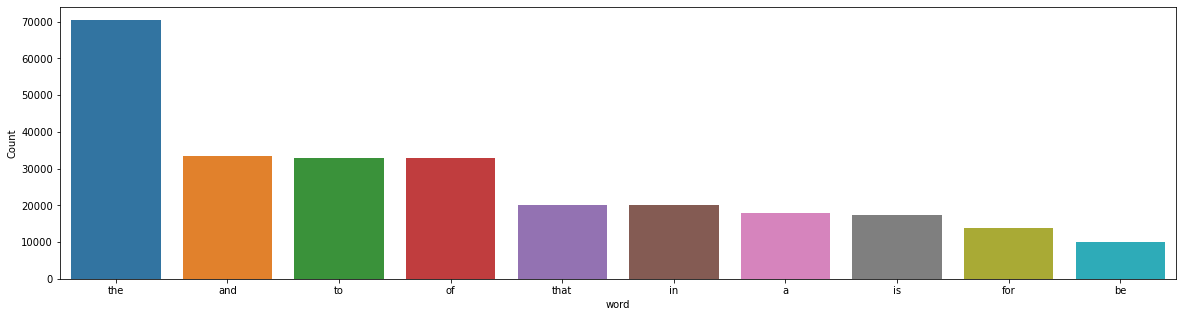

In [6]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Document number: %d'% (len(docs)))
freq_words(df[2],10) 

Tokens number: 19221


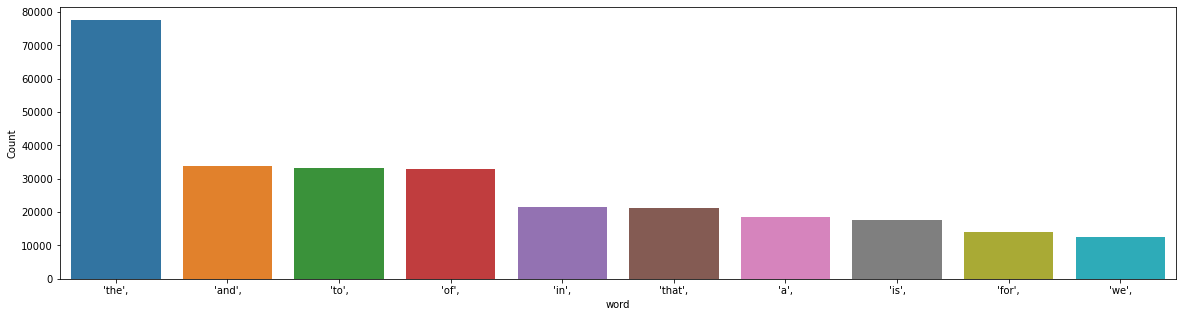

In [7]:
#Tokenize the corpus 
docs=docs.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(docs)):
    docs[i] = tokenizer.tokenize(docs[i])

print('Tokens number: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing number: 19221


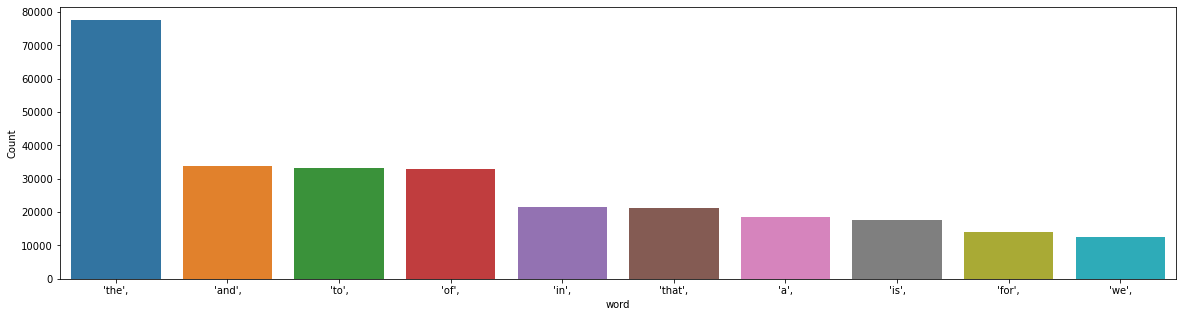

In [8]:
#Remove the number
docs = [ [token for token in doc if not token.isnumeric()] for doc in docs]

print('Tokens number after removing number: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing stop words: 18471


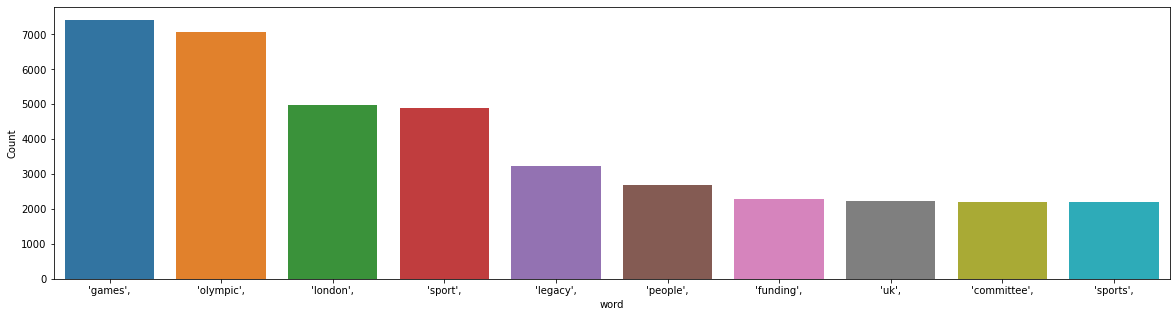

In [9]:
#remove stop words
stop_words = stopwords.words('english')
stop=[]
sw =  open("C:/Users/jason/Documents/Exeter University/business project/code/stopwords.txt","r")
for i in sw:
    stop.append(i)
sw.close()
    
stop = [myL.replace('  \n', '') for myL in stop]

stop = [myL.replace('\n', '') for myL in stop]

stop_words.extend(stop)

docs = [ [token for token in doc if not token in stop_words] for doc in docs ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing short words: 17834


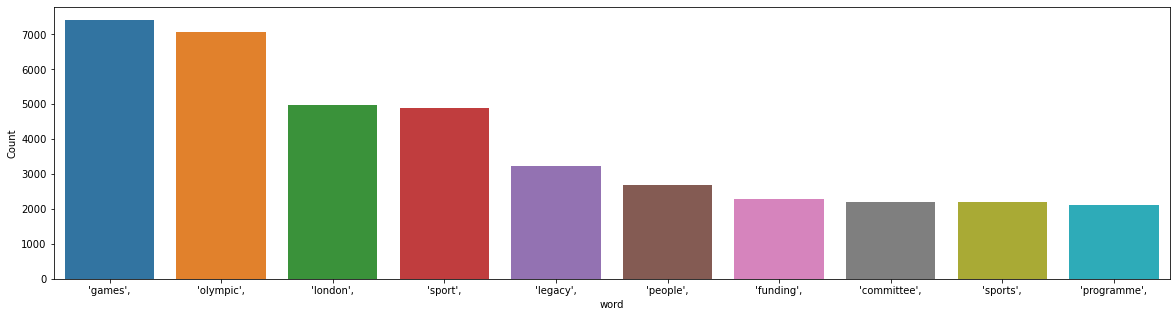

In [10]:
#Remove short words (length< min_len)
docs = [ [token for token in doc if not len(token) < min_len] for doc in docs ]
print('Tokens number after removing short words: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 15356


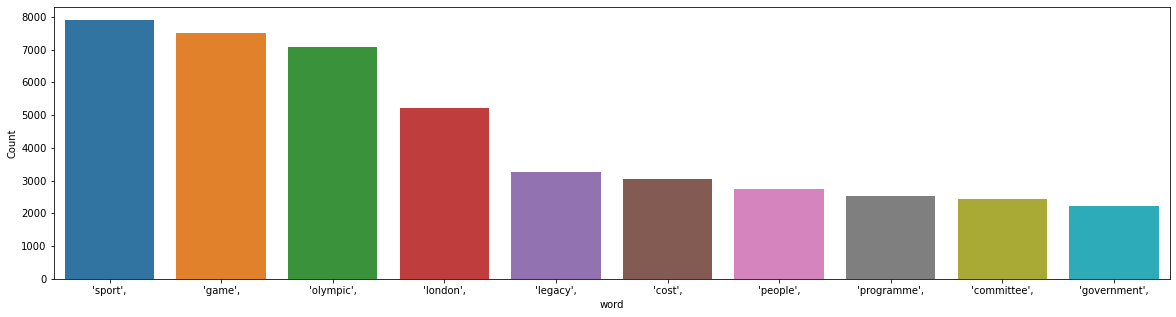

In [11]:
# Corpus Lemmatization
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(sentence):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res



if lemmatization == 1:
    for i in range (len(docs)):
        docs[i] = lemmatize_sentence(docs[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    docs = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in docs ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after adding bigram: 16140


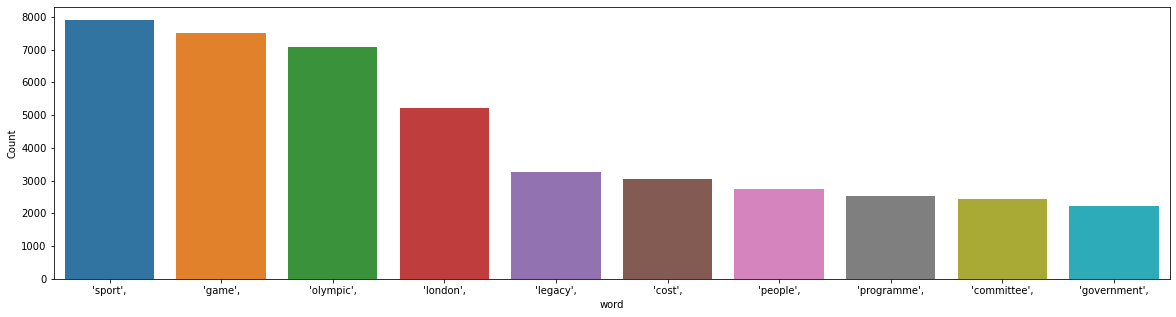

In [12]:
# Make bigram
bigrams_phases = Phrases(docs, min_count = 10)
for i in range(len(docs)):
    for token in bigrams_phases[docs[i]]:
        if '_' in token:
            docs[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

## 1.5 The LDA Model Building

In [13]:
# Build a dictionary
LOdict = Dictionary(docs)

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 16140


In [14]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 8742


In [15]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in docs]

In [16]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [17]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)
print('LDA model training complete with number of topics: ', num_topics)

LDA model training complete with number of topics:  12


In [18]:
LOldamodel.print_topics()

[(0,
  '0.035*"stadium" + 0.019*"wembley" + 0.015*"athletics" + 0.012*"city" + 0.011*"village" + 0.011*"time" + 0.011*"committee" + 0.010*"decision" + 0.010*"east" + 0.010*"issue"'),
 (1,
  '0.012*"people" + 0.009*"lord" + 0.008*"paul" + 0.007*"committee" + 0.007*"hugh" + 0.007*"process" + 0.007*"time" + 0.007*"robertson" + 0.006*"medium" + 0.006*"david"'),
 (2,
  '0.022*"authority" + 0.022*"delivery" + 0.018*"programme" + 0.015*"cost" + 0.014*"report" + 0.012*"risk" + 0.010*"project" + 0.010*"government" + 0.010*"paralympic" + 0.010*"olympic_delivery"'),
 (3,
  '0.012*"people" + 0.010*"paul" + 0.008*"cost" + 0.007*"legacy" + 0.007*"time" + 0.006*"committee" + 0.006*"deighton" + 0.006*"risk" + 0.005*"budget" + 0.005*"ticket"'),
 (4,
  '0.023*"cost" + 0.013*"report" + 0.011*"lottery" + 0.011*"budget" + 0.010*"billion" + 0.010*"committee" + 0.009*"delivery" + 0.008*"department" + 0.008*"government" + 0.007*"project"'),
 (5,
  '0.014*"cost" + 0.013*"report" + 0.013*"public" + 0.012*"jonat

In [ ]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = docs, dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score ', coherence_type,'=', coherence_lda, ' with number of topics=', num_topics)

In [ ]:
# Plot Cohernece Score
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topic in range(start, limit, step):
        model=LdaModel(
            corpus = corpus,
            id2word = id2word,
            chunksize = chunksize,
            alpha = alpha,
            eta = eta,
            iterations = iterations,
            num_topics = num_topic,
            passes = num_passes,
            eval_every = eval_every,
            random_state = random_state
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=LOdict, corpus=LOcorpus, texts=docs, start=1, limit=40, step=1)

# Show plot
import matplotlib.pyplot as plt
limit=40;start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.xticks(py.arange(0, 40, step=1))
plt.rcParams['figure.figsize'] = (20,10)
plt.show()

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.126909 -0.192811       1        1   2.220757
1      0.029365 -0.010204       2        1   5.282225
2     -0.206482 -0.008251       3        1  10.503309
3     -0.003407 -0.017659       4        1   9.358615
4     -0.151763 -0.034748       5        1  10.694741
5     -0.078637 -0.035562       6        1   6.777137
6      0.001446  0.066202       7        1  17.148775
7      0.123970 -0.104627       8        1   5.887883
8     -0.102898  0.050964       9        1   6.368142
9      0.124078  0.065494      10        1   2.116464
10     0.006470  0.032442      11        1  19.265868
11     0.130949  0.188760      12        1   4.376084, topic_info=          Term         Freq        Total Category  logprob  loglift
447     people  2731.000000  2731.000000  Default  30.0000  30.0000
592    stadium  1021.000000  1021.000000  Default  29.0000  29.0000
176   delivery  1836.000000  1836.000000  Default  28.0000  28.0000
1125      cost  3053.000000  3053.000000  Default  27.0000  27.0000
1571      park  1553.000000  1553.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
390      mayor    81.970191   737.885949  Topic12  -5.3428   0.9316
618    support    88.381262  1474.895116  Topic12  -5.2675   0.3143
86       build    77.228855   776.257960  Topic12  -5.4024   0.8213
895       pool    68.487503   344.751620  Topic12  -5.5225   1.5128
1609    school    67.129805   760.435091  Topic12  -5.5426   0.7018

[1075 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         1  0.049932   absolutely
1         2  0.158118   absolutely
1         4  0.249661   absolutely
1         5  0.054093   absolutely
1         6  0.116508   absolutely
...     ...       ...          ...
5561      3  0.969056  wwwnaoorguk
703       1  0.139544         york
703       5  0.055818         york
703       8  0.809354         york
1667      1  0.900515       yousir

[3464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

## 3 Corpus Classification

### 3.1 PARS Corpus Reading 

In [21]:
pf = pd.read_csv('Olympics-ALL-PARS-old.csv', header = None, error_bad_lines = False)

b'Skipping line 5: expected 3 fields, saw 9\nSkipping line 37: expected 3 fields, saw 5\nSkipping line 41: expected 3 fields, saw 5\nSkipping line 81: expected 3 fields, saw 5\nSkipping line 106: expected 3 fields, saw 5\nSkipping line 107: expected 3 fields, saw 7\nSkipping line 108: expected 3 fields, saw 5\nSkipping line 112: expected 3 fields, saw 5\nSkipping line 126: expected 3 fields, saw 5\nSkipping line 127: expected 3 fields, saw 5\nSkipping line 139: expected 3 fields, saw 5\nSkipping line 140: expected 3 fields, saw 5\nSkipping line 142: expected 3 fields, saw 5\nSkipping line 149: expected 3 fields, saw 5\nSkipping line 162: expected 3 fields, saw 5\nSkipping line 163: expected 3 fields, saw 5\nSkipping line 186: expected 3 fields, saw 5\nSkipping line 188: expected 3 fields, saw 5\nSkipping line 190: expected 3 fields, saw 5\nSkipping line 191: expected 3 fields, saw 5\nSkipping line 194: expected 3 fields, saw 5\nSkipping line 213: expected 3 fields, saw 5\nSkipping line

In [22]:
pars = []
pars = pf[col]

### 3.2 PARS Corpus Processing

Document number: 22764


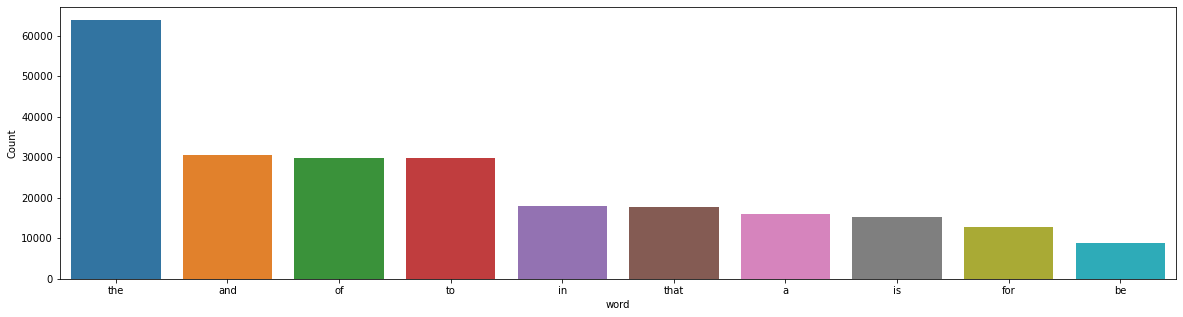

In [23]:
print('Document number: %d'% (len(pars)))
freq_words(pars,10) 

Tokens number: 18540


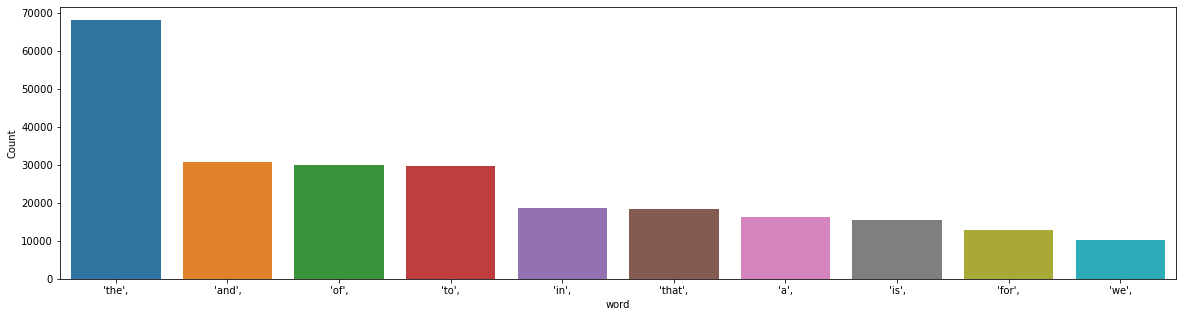

In [24]:
#Tokenize the corpus 
pars= pars.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(pars)):
    pars[i] = tokenizer.tokenize(pars[i])

print('Tokens number: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing number: 18540


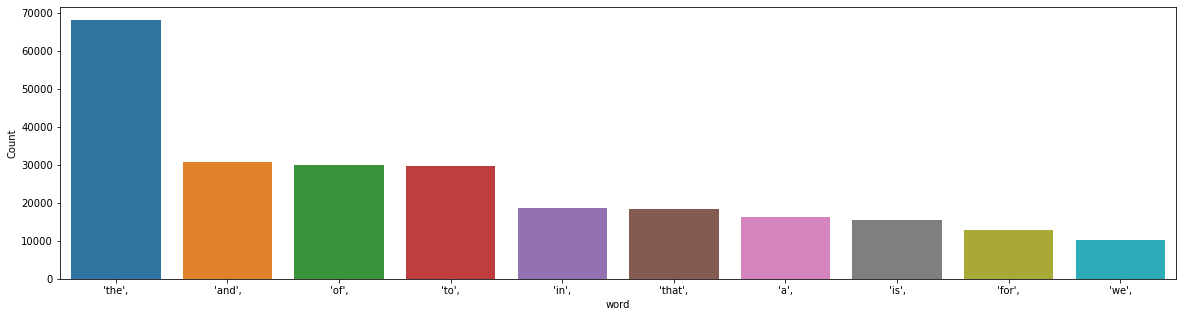

In [25]:
#Remove the number
pars = [ [token for token in doc if not token.isnumeric()] for doc in pars]

print('Tokens number after removing number: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing stop words: 17793


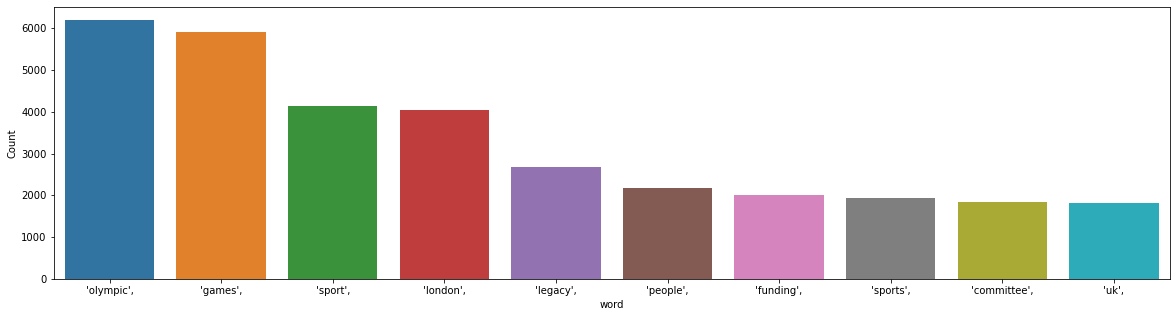

In [26]:
#Reomve stop words
pars = [ [token for token in doc if not token in stop_words] for doc in pars ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing short words: 17176


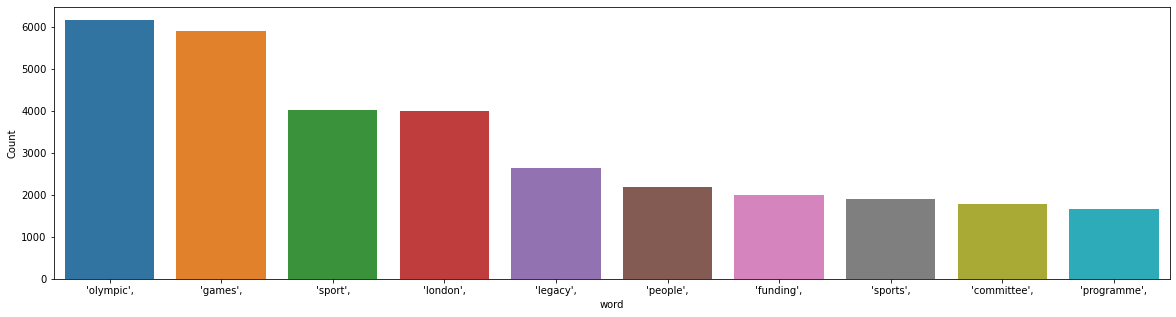

In [27]:
#Remove short words (length< min_len)
pars = [ [token for token in doc if not len(token) < min_len] for doc in pars ]
print('Tokens number after removing short words: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 14731


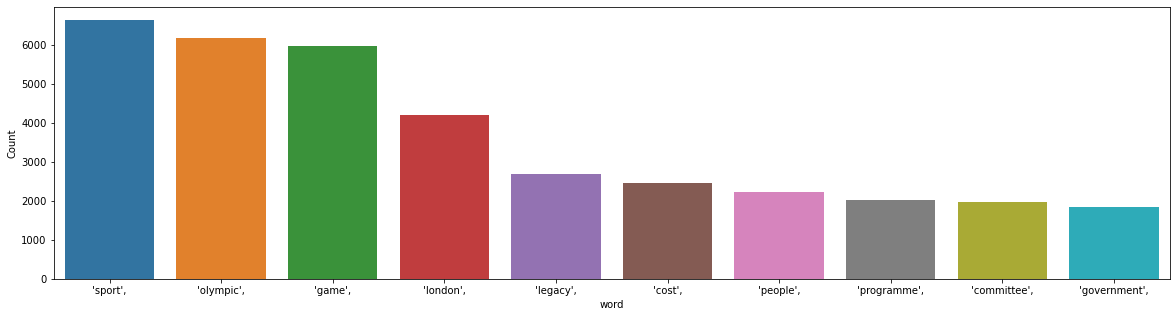

In [28]:
# Corpus Lemmatization
if lemmatization == 1:
    for i in range (len(pars)):
        pars[i] = lemmatize_sentence(pars[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    pars = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in pars ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after adding bigram: 15440


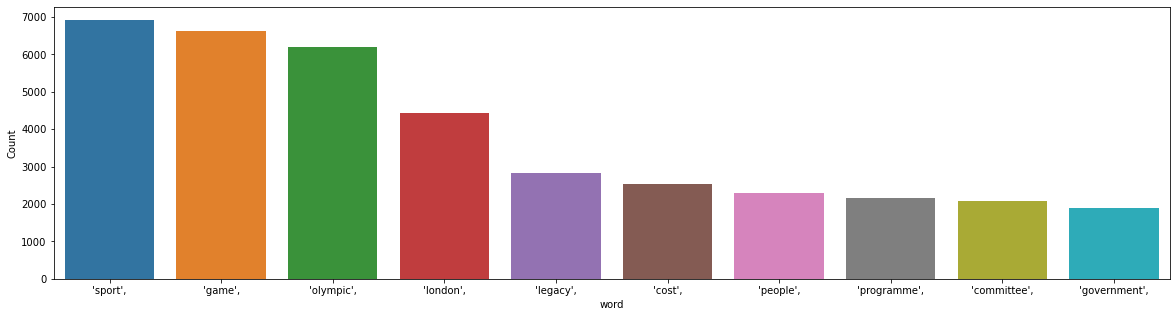

In [29]:
# Make bigram
P_bigrams_phases = Phrases(pars, min_count = 10)
for i in range(len(pars)):
    for token in P_bigrams_phases[pars[i]]:
        if '_' in token:
            pars[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

### 3.3 Classify PARAS

### 3.3.1 Parameter Setting

In [228]:
minimum_probability = 0.5 #Topics with an assigned probability lower than this threshold will be discarded.
rank = 10                          #Set rank of for for topic 
topic = 0                           #Topic filter of the Highest ranked paragraphs

### 3.3.2 PARS Classification

In [110]:
classifer = list()
for p in pars:
    bow = LOdict.doc2bow(p)
    belong = LOldamodel.get_document_topics(bow,minimum_probability = 0,per_word_topics=False)
    classifer.append(belong)

classiferdf = pd.DataFrame(classifer)

classifer_par = pd.concat([pf.iloc[:,0:3],classiferdf],axis=1)

In [32]:
Pcorpus = [LOdict.doc2bow(doc) for doc in pars]
#Make the Dataframe of the highest probable topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus,per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
#    print(bz,listj[bz], i)
    MTopics.append([bz, listj[bz]])

MTopics = pd.DataFrame(MTopics)

classifer_document = pd.concat([pf.iloc[:,0:2],MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document.columns = ["Paragraph No.","Souce","The Highest Probable Topic", "Probability","Text"]

In [76]:
#1.	Highest N ranked paragraphs for topic K
classifer_document[classifer_document['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')

,Paragraph No.,Souce,The Highest Probable Topic,Probability,Text
332,384,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.567034,This just will not do It really will not do M...
329,381,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.529066,I understand all of that Mr Draper but it get...
323,369,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.527525,If could follow that through I spent many hou...
337,391,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.502808,Alan Keen I was aware and Ian Fytche is right ...
325,371,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.500781,I was not too far out That is a huge amount o...
281,314,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_192-...,0,0.460686,Mr Draper I realise that you come before us a...
327,375,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.442367,I will come back to you in a moment Frank but...
289,322,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_192-...,0,0.428365,It is axiomatic Derek But if Manchester City ...
399,446,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_62-7...,0,0.419213,Could I just follow up Mr Keens question When...
282,315,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_192-...,0,0.418541,Well Mr Draper in that case let me ask you th...


In [34]:
#2.	Highest N ranked paragraphs overall
classifer_document.nlargest(rank, 'Probability')

,Paragraph No.,Souce,The Highest Probable Topic,Probability,Text
15756,16064,Olympics-All-PARS/NewChunk6/NAO_Preparations_f...,2,0.652984,The Delivery Authoritys Programme Baseline of...
6838,7101,Olympics-All-PARS/NewChunk3/Report_and_Minutes...,6,0.628700,Cyclists Touring Club DolmetSch Historical Dan...
332,384,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.567034,This just will not do It really will not do M...
13681,13984,Olympics-All-PARS/NewChunk5a/NAO_Preparations_...,2,0.565806,n million hereafter referred to as the Olympi...
4975,5228,Olympics-All-PARS/NewChunk3/PAC_-_Risk_assessm...,4,0.546905,The public sector funding package for the Gam...
7953,8248,Olympics-All-PARS/NewChunk3/Report_and_Minutes...,6,0.534913,BACTA British Association of Leisure Parks Pie...
6835,7098,Olympics-All-PARS/NewChunk3/Report_and_Minutes...,6,0.529269,Cycling Time Trials Dalcroze Society Duke of E...
329,381,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.529066,I understand all of that Mr Draper but it get...
6561,6824,Olympics-All-PARS/NewChunk3/Report_and_Minutes...,8,0.528556,Estimate OLDs annual income Specify the sour...
323,369,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.527525,If could follow that through I spent many hou...


In [35]:
#3.	Highest N ranked paragraphs from each topic K
classifer_document.groupby(by='The Highest Probable Topic').apply(lambda x:x.nlargest(rank, 'Probability'))

Paragraph No.  \
The Highest Probable Topic                        
0                          332              384   
                           329              381   
                           323              369   
                           337              391   
                           325              371   
...                                         ...   
11                         17598          17930   
                           16411          16739   
                           17684          18016   
                           16418          16746   
                           1233            1284   

                                                                              Souce  \
The Highest Probable Topic                                                            
0                          332    Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...   
                           329    Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...   
                           323    Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...   
                           337    Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...   
                           325    Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...   
...                                                                             ...   
11                         17598  Olympics-All-PARS/NewChunk6/Written_evidence_s...   
                           16411  Olympics-All-PARS/NewChunk6/Oral_evidence_-_17...   
                           17684  Olympics-All-PARS/NewChunk6/Written_evidence_s...   
                           16418  Olympics-All-PARS/NewChunk6/Oral_evidence_-_17...   
                           1233   Olympics-All-PARS/NewChunk1/Written_evidence_-...   

                                  The Highest Probable Topic  Probability  \
The Highest Probable Topic                                                  
0                          332                             0     0.567034   
                           329                             0     0.529066   
                           323                             0     0.527525   
                           337                             0     0.502808   
                           325                             0     0.500781   
...                                                      ...          ...   
11                         17598                          11     0.409059   
                           16411                          11     0.382126   
                           17684                          11     0.381937   
                           16418                          11     0.373263   
                           1233                           11     0.370479   

                                                                               Text  
The Highest Probable Topic                                                           
0                          332     This just will not do It really will not do M...  
                           329     I understand all of that Mr Draper but it get...  
                           323     If could follow that through I spent many hou...  
                           337    Alan Keen I was aware and Ian Fytche is right ...  
                           325     I was not too far out That is a huge amount o...  
...                                                                             ...  
11                         17598  Hackney has worked closely with the other four...  
                           16411  Sir Robin Wales We have been involved I should...  
                           17684  We have undertaken much work connecting local ...  
                           16418  Mr Pipe I think it probably depends from where...  
                           1233    Regeneration is already underway in East Lond...  

[120 rows x 5 columns]

In [226]:
#4.	Highest N ranked paragraphs where the belong() function is greater than the threshold for M topics at a time
T_MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus, minimum_probability = minimum_probability, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    if listj:
        bz=listj.index(max(listj))
        topic= ','.join(str(a) for a in re.findall(r"(\d+),",str(max(i))) )
#        print(bz,listj[bz],topic)
        T_MTopics.append([int(topic), listj[bz]])
    else:
        T_MTopics.append(['None',0])
        

T_MTopics = pd.DataFrame(T_MTopics)

classifer_document_threshold = pd.concat([pf.iloc[:,0:2],T_MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document_threshold.columns = ["Paragraph Number","Souce Filename","The Highest Probable Topic", "Probability","Text"]

In [229]:
classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')

,Paragraph Number,Souce Filename,The Highest Probable Topic,Probability,Text
332,384,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.567046,This just will not do It really will not do M...
329,381,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.529059,I understand all of that Mr Draper but it get...
323,369,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.527522,If could follow that through I spent many hou...
337,391,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.502808,Alan Keen I was aware and Ian Fytche is right ...
325,371,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-...,0,0.500782,I was not too far out That is a huge amount o...
